### Self-supervised Learning of Visual Representations

In this tutotial, you will investigate two popular self-supervised strategies for learning visual representations. In particular, you will reproduce results from the following seminal papers:

* Caron, M., Bojanowski, P., Joulin, A., & Douze, M. (2018). **Deep clustering for unsupervised learning of visual features**. In Proceedings of the European conference on computer vision (ECCV) (pp. 132-149),
  
* Chen, T., Kornblith, S., Norouzi, M., & Hinton, G. (2020, November). **A simple framework for contrastive learning of visual representations**. In International conference on machine learning (pp. 1597-1607). PmLR.

Both methods aim to learn task-agnostic features from an unsupervised data set by minimizing a self-supervised loss function.

#### Structure of the repo

The code for running this tutorial is available at https://github.com/Romain3Ch216/DL4IA/tree/main/docs/tutorials/learning_visual_representations. We suggest to fork the [DL4IA](https://github.com/Romain3Ch216/DL4IA) repo and clone your fork:
```
git clone git@github.com:<your-username>/DL4IA.git

```

The repo contains the following files, with code **to be completed**.
```
learning_visual_representations
├── configs
    ├── dc_exp.yaml
    ├── ...
├── learning
    ├── transformations.py
    ├── nce_loss.py
├── models
    ├── alexnet.py
    ├── projection_head.py
├── util_scripts
├── activations.py
├── contrastive_training.py
├── datasets.py
├── dc_exp.py
├── imagenet_mnist_exp.py
├── learning_visual_representations.ipynb
├── utils.py
```

#### 1. Deep Clustering

The Deep Clustering (DC) algorithm is based on the assumption that convolutional layers provide a strong prior on the input signal. The authors base their intuition on an empirical result obtained by [Noroozi et al. (2016)](https://www.researchgate.net/profile/Mehdi-Noroozi-2/publication/301837491_Unsupervised_Learning_of_Visual_Representations_by_Solving_Jigsaw_Puzzles/links/58385c8808aed5c614885771/Unsupervised-Learning-of-Visual-Representations-by-Solving-Jigsaw-Puzzles.pdf) who observed that "a multilayer perceptron classifier on top of the last convolutional layer of a random AlexNet [a CNN] achieves 12% in accuracy on ImageNet while the chance is at 0.1%". Therefore, the goal of the Deep Clustering algorithm is to "exploit this weak signal to bootstrap the discriminative power of a convnet".

Let's verify this result ourself! As in the paper, we are going to use the famous [ImageNet](https://image-net.org/) dataset, or at least a small subset of it, and the convolutional network [AlexNet](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf).

In [1]:
import yaml
import matplotlib.pyplot as plt
import torch
from models.alexnet import alexnet
from datasets import SubsetImageNet
import utils

In [2]:
with open('configs/dc_exp.yaml', 'r') as file:
    cfg = yaml.safe_load(file)

subset_classes = cfg['subset_classes']

dataset = SubsetImageNet(
    cfg['data_folder'], 
    cfg['labels_file'], 
    classes=subset_classes
    )

First, let's take a look at the dataset.

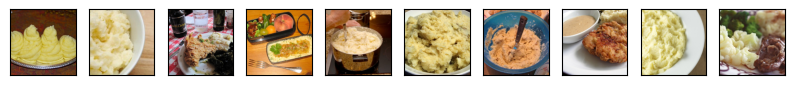

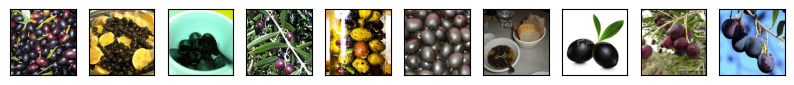

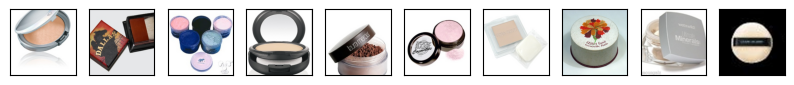

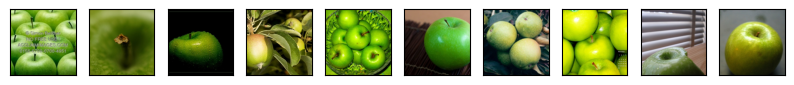

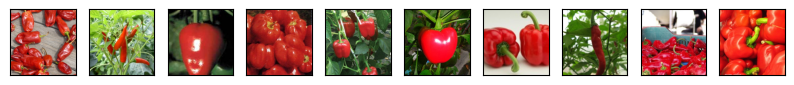

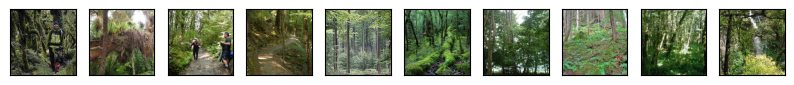

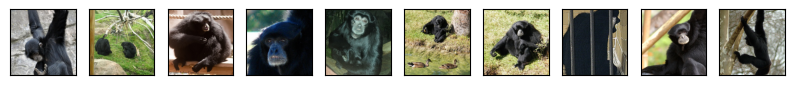

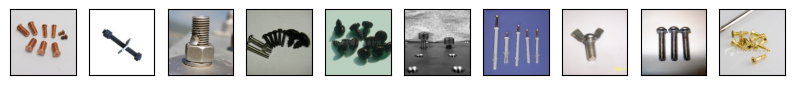

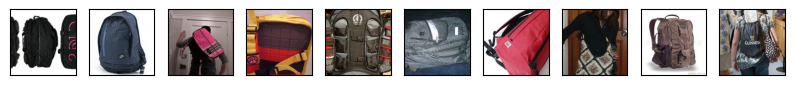

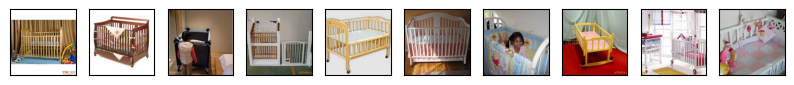

In [3]:
data, labels = utils.dataset2tensor(dataset)
# data = data.permute(0, 2, 3, 1)
for class_id in range(len(subset_classes)):
    utils.show_samples_per_class(data, labels, class_id, n_samples=10, figsize=(10, 30))

Now, let's visualize the filters of the first layer of an AlexNet at initialization. Can those random filters still extract useful features for classification?

In [4]:
model = alexnet(out=len(subset_classes))
conv1 = model.features[0]

In [5]:
model.features

Sequential(
  (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding

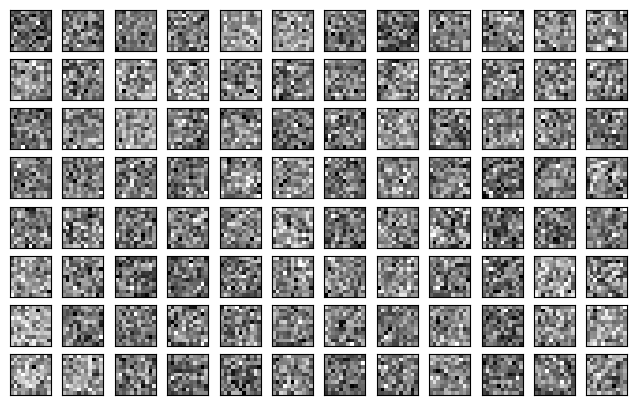

In [6]:
fig, ax = plt.subplots(8, 12, figsize=(8, 5))
weights = conv1.weight.data.cpu().numpy()
for i in range(weights.shape[0]):
    ax[i // 12, i % 12].imshow(weights[i, 0], cmap='gray')
    ax[i // 12, i %12].set_xticks([])
    ax[i // 12, i %12].set_yticks([])
plt.show()

#### 1.1 "Convolutional layers provide a strong prior on the input signal"

We're going to reproduce the experiment of Noroozi et al. (2016) on our subset of ImageNet. Update the `freeze_feature_layers` in the `AlexNet` class to freeze its convolutional layers. Run the `dc_exp.py` script. **Is the model better than a random guess on the test set?**

In [7]:
model = alexnet(out=len(subset_classes), freeze_features=True)
conv1 = model.features[0].weight
## todo

#### 1.2 Visualization of the convolutional filters

Now, we are going to try to analyse the features learned through Deep Clustering. Specifically, you are going to reproduce figures of the paper that visualise the convolutional filters. Let's load the pretrained weights of AlexNet trained by DC.

##### 1.2.1 First layer

In [8]:
import torch
import torchvision.transforms.v2 as T

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pretrained_params = torch.load('/home/alan/tuto_Romain_Thoreau/data_td3/pretrained_alexnet_dc.tar',
                               map_location=device)

out_shape = pretrained_params['top_layer.weight'].shape[0]


model = alexnet(out=out_shape, sobel=True, freeze_features=True)
model.load_state_dict(pretrained_params)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(2, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d

Visualize the filters of the first layer, as above, and as in the right part of Fig. 3 in the paper. What kind of features do those filters extract?

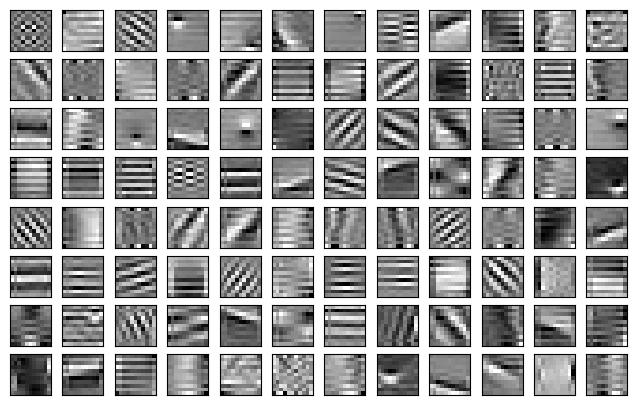

In [10]:
conv1 = model.features[0]
weights = conv1.weight.data.cpu().numpy()

fig, ax = plt.subplots(8, 12, figsize=(8, 5))
for i in range(weights.shape[0]):
    ax[i // 12, i %12].imshow(weights[i, 1], cmap='gray')
    ax[i // 12, i %12].set_xticks([])
    ax[i // 12, i %12].set_yticks([])
plt.show()

##### 1.2.2 Probing deeper layers

Would it make sense to visualize the filters of the deeper layers as we have done for the first layer? Let's reproduce the Fig. 5 of the paper:

* compute the activations of the last layer of the convnet for every sample in the dataset,

* show the top-10 images that are activated by the filters 0 and 33.

In Fig. 5 of the paper, what kind of images mostly activate the filters 0 and 33? Is it consistent with your results?

Note: If a convolutional layer outputs a (n_channel x height x width) tensor, the activation is defined as the average over the spatial dimensions, leading to a n_channel-dimensional tensor.



In [11]:
from activations import compute_dataset_activations

In [12]:
transformations = {
    'to_tensor': T.ToTensor(),
    'center_crop': T.CenterCrop(224),
    'normalize': T.Normalize(mean=cfg['data_mean'], std=cfg['data_std']),
}

dataset.transform = T.Compose(
    [transformations[k] for k in cfg['transforms']]
    )

/home/alan/miniconda3/envs/rtx4070/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [13]:
activations = compute_dataset_activations(model, dataset, layer=5)

Compute activations over dataset for layer 5: 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


In [14]:
from activations import compute_filter_activations, get_topk_images

filter_ids = [0, 33]

activations_dict, indices = compute_filter_activations(model, dataset, filter_ids)
topk_indices = get_topk_images(activations_dict, indices)

top10_activations_f0 = topk_indices[0]   # Top 10 images pour le filtre 0
top10_activations_f33 = topk_indices[33] # Top 10 images pour le filtre 33

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:01<00:00, 15.99it/s]


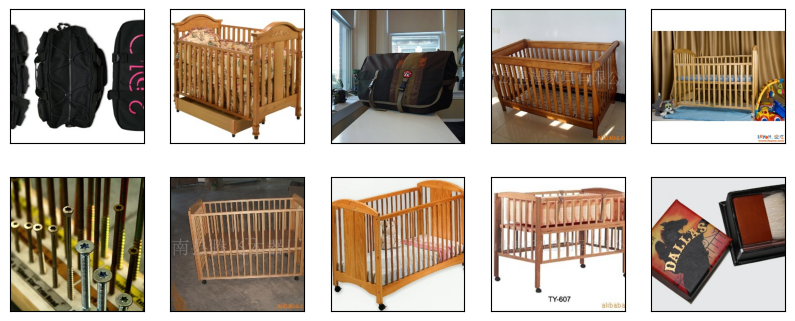

In [15]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
dataset.transform = None
for i, sample_id in enumerate(top10_activations_f0):
    img, _ = dataset.__getitem__(sample_id)
    img = img.permute(1, 2, 0)
    ax[i // 5, i % 5].imshow(img)
    ax[i // 5, i % 5].set_xticks([])
    ax[i // 5, i % 5].set_yticks([])
plt.show()

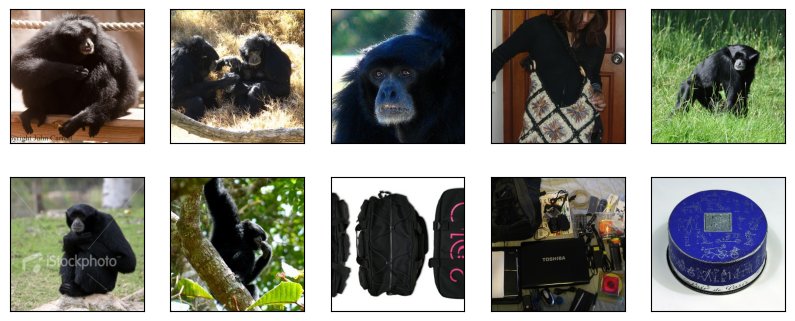

In [16]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
dataset.transform = None
for i, sample_id in enumerate(top10_activations_f33):
    img, _ = dataset.__getitem__(sample_id)
    img = img.permute(1, 2, 0)
    ax[i // 5, i % 5].imshow(img)
    ax[i // 5, i % 5].set_xticks([])
    ax[i // 5, i % 5].set_yticks([])
plt.show()

Another way to "visualize" deeper layers is to find images that maximize the response to a convolutional filter. In ["Understanding Neural Networks Through Deep Visualization"](https://arxiv.org/pdf/1506.06579), Yosinski et al. introduce an optimization algorithm in image space with a regularization to produce recognizable and interpretable vizualizations.

In [17]:
import importlib
import activations
importlib.reload(activations)

<module 'activations' from '/home/alan/tuto_Romain_Thoreau/DL4IA/docs/tutorials/learning_visual_representations/activations.py'>

In [18]:
from activations import maximize_img_response

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
max_img_f0 = maximize_img_response(model, device=device, n_it=50000, img_size=224, layer=5, filter_id=0)
max_img_f145 = maximize_img_response(model, device=device, n_it=50000, img_size=224, layer=5, filter_id=33)

Gradient ascent in image space:   0%|          | 1/50000 [00:00<3:47:06,  3.67it/s]/home/alan/miniconda3/envs/rtx4070/lib/python3.12/site-packages/torch/autograd/graph.py:841: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [1, 3, 224, 224], strides() = [150528, 50176, 224, 1]
param.sizes() = [1, 3, 224, 224], strides() = [3, 1, 3, 672] (Triggered internally at /pytorch/torch/csrc/autograd/functions/accumulate_grad.h:240.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Gradient ascent in image space: 100%|██████████| 50000/50000 [01:57<00:00, 425.19it/s] 


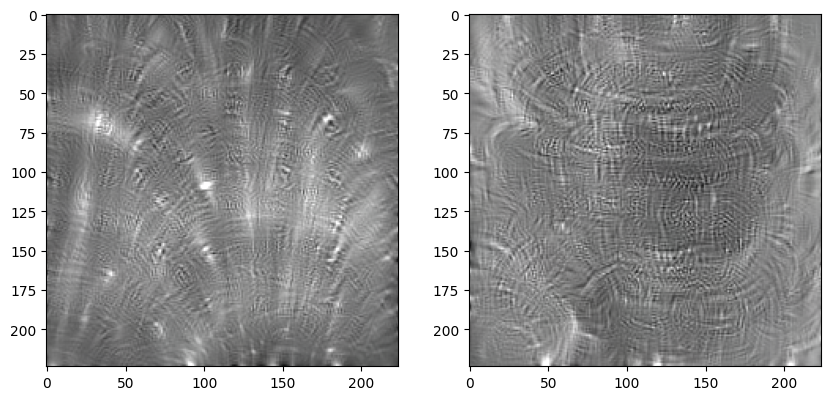

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(max_img_f0)
ax[1].imshow(max_img_f145)
plt.show()

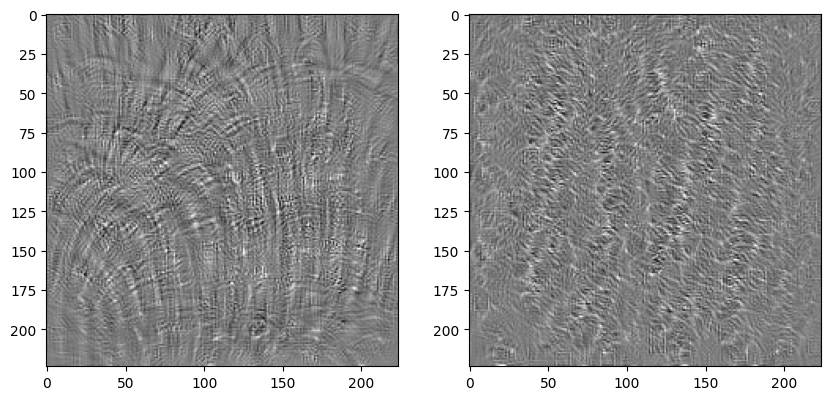

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(max_img_f0)
ax[1].imshow(max_img_f145)
plt.show()

Are those images interpretable? Are there consistent with the images above that activate the filters the most?

#### 2. Contrastive Learning

As we have seen, the high-level idea of contrastive learning (CL) is to maximize the similarity of different views of the data in the latent space. One seminal CL algorithm, named simCLR, was introduced in (Chen et al., 2020), illustrated in the figure below, taken from the original article:
<center>
   <img alt="fig_contrastive" src="figures/fig_contrastive.png" width=300> 
</center>
<center>
    Source: <a href="https://proceedings.mlr.press/v119/chen20j/chen20j.pdf">https://proceedings.mlr.press/v119/chen20j/chen20j.pdf</a>
</center>
In this tutorial, we are going to use AlexNet as the base encoder $f(\cdot)$, and a MLP with one hidden layer as the projection head $g(\cdot)$. Regarding the transformations, we will sample a transformation $t$ from a sequence of random cropping with resizing, color distortion, Gaussian blur and normalization. The sequence is fixed, but the transformations themselves are random.

In [21]:
from datasets import ContrastiveDataset
from learning.transformations import DataTransformation
from utils import deprocess_image

In [23]:
with open('configs/contrastive_training.yaml', 'r') as file:
    cfg = yaml.safe_load(file)

transform = DataTransformation(cfg)

dataset = ContrastiveDataset(
    cfg['data_folder'], 
    cfg['labels_file'], 
    classes=cfg['subset_classes'],
    transform=transform()
    )

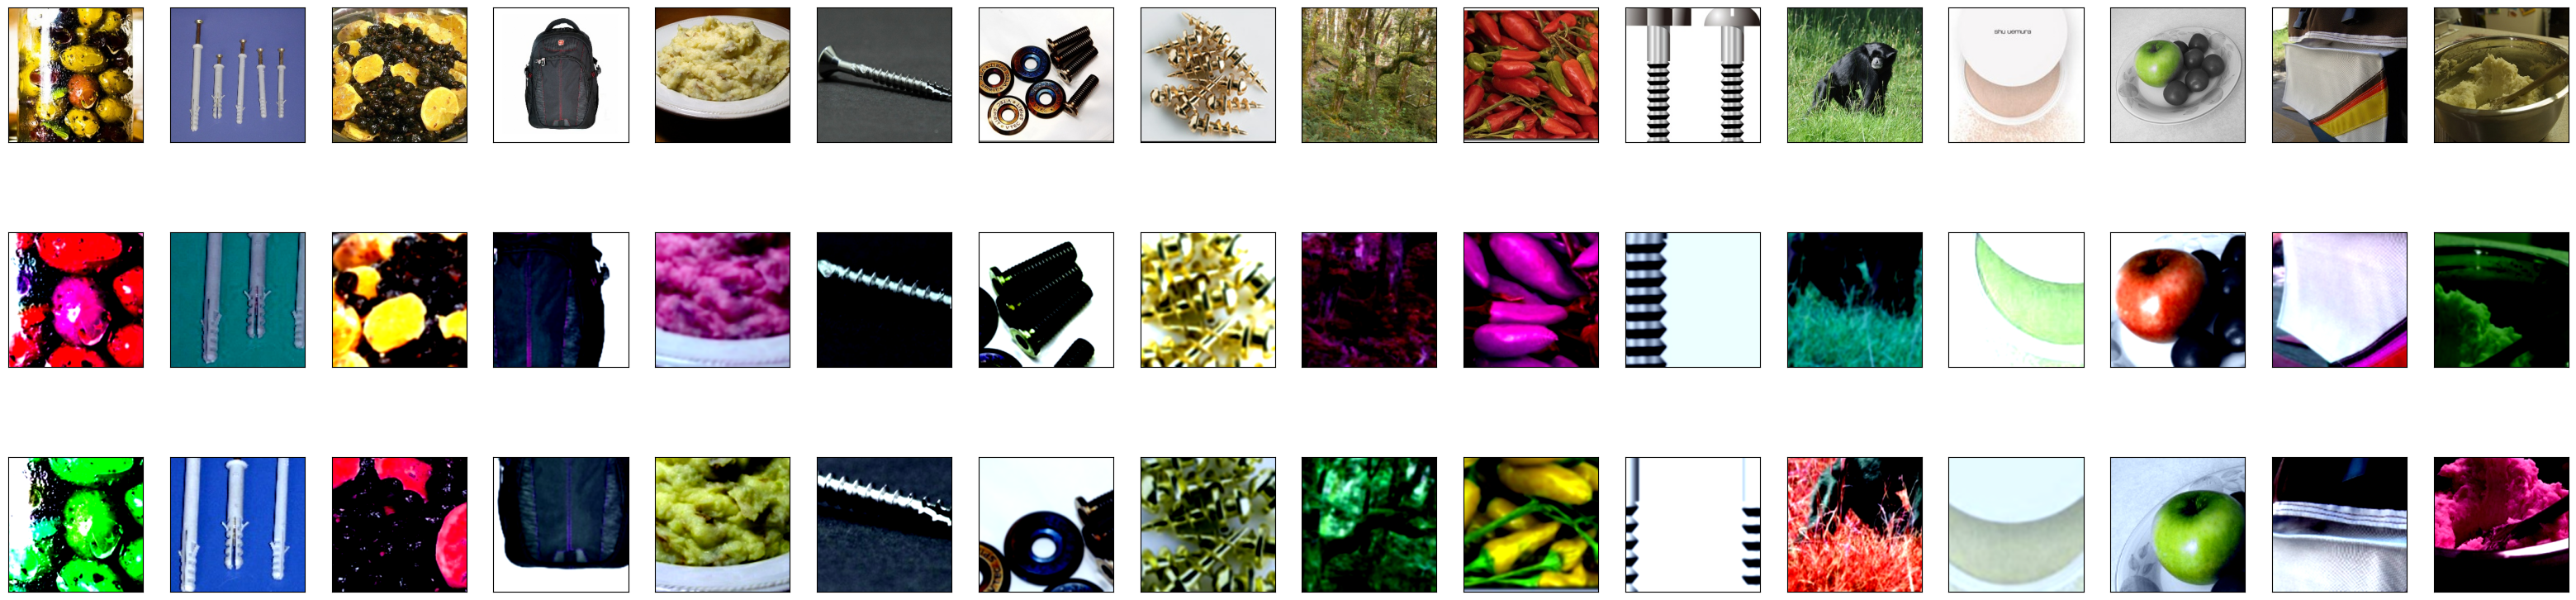

In [25]:
torch.manual_seed(3)

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,
    shuffle=True
)

batch = next(iter(data_loader))
imgs, imgs1, imgs2 = batch

fig, ax = plt.subplots(3, imgs.shape[0], figsize=(40, 10))
for i in range(imgs.shape[0]):
    ax[0, i].imshow(imgs[i].permute(1, 2, 0))
    ax[1, i].imshow(deprocess_image(imgs1[i], cfg['data_mean'], cfg['data_std']))
    ax[2, i].imshow(deprocess_image(imgs2[i], cfg['data_mean'], cfg['data_std']))
    for j in range(3):
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
plt.show()

If we would compute features with AlexNet pretrained with Deep Clustering, how similar or dissimilar would those different views of the data be?

In [ ]:
with torch.no_grad():
    # Déplacer les images sur le même device que le modèle
    imgs1_device = imgs1.to(next(model.parameters()).device)
    imgs2_device = imgs2.to(next(model.parameters()).device)
    
    # Appliquer le filtre Sobel si nécessaire
    x1 = imgs1_device
    x2 = imgs2_device
    
    if model.sobel is not None:
        x1 = model.sobel(x1)
        x2 = model.sobel(x2)
    
    # Extraire les features directement après les convolutions
    # Deep Clustering utilise les features après les convolutions, avant le classifier
    x1 = model.features(x1)
    x2 = model.features(x2)
    
    # Moyenne globale : moyenne sur les dimensions spatiales (H, W)
    # On réduit [batch_size, 256, 6, 6] à [batch_size, 256]
    x1 = torch.nn.functional.adaptive_avg_pool2d(x1, (1, 1)).squeeze(-1).squeeze(-1)
    x2 = torch.nn.functional.adaptive_avg_pool2d(x2, (1, 1)).squeeze(-1).squeeze(-1)
    
    # Normaliser les features pour le calcul de la similarité cosinus
    x1_norm = torch.nn.functional.normalize(x1, dim=1)
    x2_norm = torch.nn.functional.normalize(x2, dim=1)
    
    # Calculer la matrice de similarité cosinus entre toutes les paires
    # Résultat : [batch_size, batch_size]
    # sim[i,j] = cosinus(features1[i], features2[j])
    sim = torch.matmul(x1_norm, x2_norm.T)

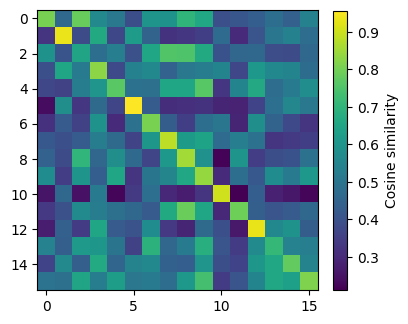

tensor([ 0,  1,  7,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       device='cuda:0')


In [31]:
fig = plt.figure(figsize=(4, 4))
plt.imshow(sim.cpu())
plt.colorbar(label='Cosine similarity', fraction=0.045)
plt.show()
print(torch.argmax(sim, dim=1))

In [52]:
sim = ...

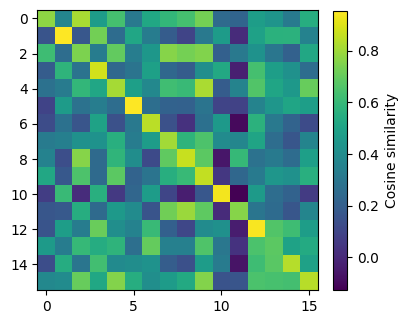

tensor([ 2,  1,  7,  3,  9,  5,  6,  7,  8,  9, 10,  8, 12,  6, 14, 15],
       device='cuda:0')


In [53]:
fig = plt.figure(figsize=(4, 4))
plt.imshow(sim.cpu())
plt.colorbar(label='Cosine similarity', fraction=0.045)
plt.show()
print(torch.argmax(sim, dim=1))

#### 2.1. SimCLR learning algorithm

Now, let's implement the simCLR algorithm, detailed in Algorithm 1 of the [paper](https://proceedings.mlr.press/v119/chen20j/chen20j.pdf). In order to compute the loss efficiently, we are going to concatenate $z_1$ and $z_2$ (of size N x d), and compute the pairwise similarity in a (2N x 2N) matrix, as illustrated below. In order to compute the cost function $l(i,j)$, we will use the PyTorch cross entropy loss. To discard the $k = i$ terms in the denominator of the cost function $l(i,j)$, *i.e.* the diagonal elements of the similarity matrix, we will set the diagonal terms equal to a very large negative value. 

<center>
    <img alt="matrix_similarity" src="figures/sim.png" width=300>
</center>

Train AlexNet with SimCLR, starting from the pretrained DC parameters at initialization, except for the last layer that outputs 10000-dimensional features. Replace this last dense layer in order to output d_model-dimensional features.

In [54]:
model = ...

AlexNet(
  (features): Sequential(
    (0): Conv2d(2, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d

In [55]:
contrastive_sim = ...

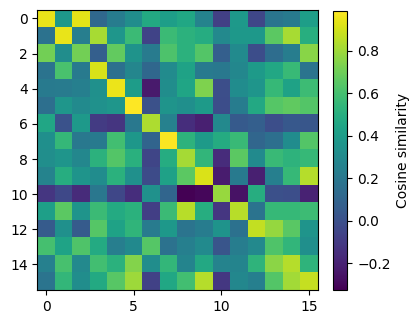

tensor([ 0,  1, 15,  3,  4,  5,  6,  7,  8,  9, 10,  8, 12,  6, 14, 15],
       device='cuda:0')

In [56]:
fig = plt.figure(figsize=(4, 4))
plt.imshow(contrastive_sim.cpu())
plt.colorbar(label='Cosine similarity', fraction=0.045)
plt.show()
torch.argmax(contrastive_sim, dim=1)

Show the difference between the cosine similarity obatined with simCLR and with DC. What can we observe?

In [57]:
diff_sim = contrastive_sim - sim

In [39]:
from utils import MidpointNormalize

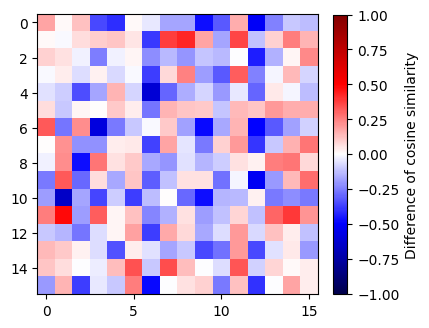

In [58]:
fig = plt.figure(figsize=(4, 4))
min_val, max_val, mid_val = -1, 1, 0
plt.imshow(diff_sim.cpu(), cmap='seismic', norm=MidpointNormalize(midpoint=mid_val,vmin=min_val, vmax=max_val))
plt.colorbar(label='Difference of cosine similarity', fraction=0.045)
plt.show()

#### 2.2 "Optimal Views Depend on the Downstream Task"

In ["What Makes for Good Views for Contrastive Learning?"](https://proceedings.neurips.cc/paper_files/paper/2020/file/4c2e5eaae9152079b9e95845750bb9ab-Paper.pdf), Tian et al. investigate the impact of the view generation in CL on downstream performance. They formalize how "the amount and type of information shared between [views, denoted as $v_1$ and $v_2$] (i.e., $I(v_1; v_2)$) determines how well we perform on downstream tasks.". Here, $I$ denotes the [mutual information](https://en.wikipedia.org/wiki/Mutual_information). In particular, they consider three situations:

 * Missing information: $I(v_1, v_2) < I(x, y)$, information about the target $y$ contained in the data $x$ has been discarded during the view generation,
  
 * Sweet spot: $I(v_1, v_2) = I(x, y)$, all shared information between $v_1$ and $v_2$ is task-relevant information,

 * Excess noise: $I(v_1, v_2) > I(x, y)$, additional shared information between views is not relevant for the downstream task, which "can lead to worse generalization".

Unsurprisingly, the best view generation (*i.e.* for extracting the most relevant features) depends on the downstream task. In order to further study how the choice of the view generation impacts the downstream performance in practice, authors have designed a toy dataset called Colorful Moving-MNIST (illustrated below). It consists of images with three factors of variation: the class of the background, the class of the digit, the position of the digit.

<center>
    <img src="figures/colorful_moving_mnist.png" alt="colorful moving mnist" width=800>
</center>
<center>
    Illustration of the Colorful-Moving-MNIST dataset. In this example, the first view $v_1$ is a sequence  of frames containing the moving digit, *e.g.*, $v_1 = x_{1:k}$. The matched second view $v^{+}_2$ share some factor with $x_t$  that $v_1$ can predict, while the unmatched view $v^{−}_2$ does not share factor with $x_t$. Source: <a href="https://proceedings.neurips.cc/paper_files/paper/2020/file/4c2e5eaae9152079b9e95845750bb9ab-Paper.pdf">(Tian et al., 2020)</a>
</center>

On this data set, their experiment consists in pre-training models with different view generations (by controlling which factors are shared between views) and evaluating the downstream performance on three tasks: the classification of the background class, of the digit class, and of the digit position. Results are shown in the Table 2 of the paper. 

We are going to reproduce Table 2 on a simplified toy dataset, that we will call Imagenet-MNIST. It consists of images from our subset of ImageNet with overlapped digits (either 1 or 7). Therefore, there are two factors of variation: the class of the background image, and the class of the digit. The two downstream tasks we consider are the background image classification, and the digit classification.

Update the `ImageNetMnist`class in `datasets.py`, and show some samples.

In [59]:
from datasets import ImageNetMnist, collate_views

In [60]:
shared_feature = 'background' # or 'digit'

with open(f'configs/contrastive_training_{shared_feature}.yaml', 'r') as file:
    cfg = yaml.safe_load(file)
    
dataset = ImageNetMnist(
    imagenet_data_folder=cfg['imagenet_data_folder'], 
    imagenet_labels_file=cfg['imagenet_labels_file'], 
    imagenet_classes=cfg['imagenet_classes'], 
    mnist_data_folder=cfg['mnist_data_folder'],
    shared_feature=cfg['shared_feature'])

transform = DataTransformation(cfg)
if cfg['shared_feature'] == 'background' or 'background' in cfg['shared_feature']:
    dataset.transform1 = transform(['random_cropping', 'resize'])
    dataset.transform2 = transform(['gaussian_blur', 'normalize'])
elif cfg['shared_feature'] == 'digit':
    dataset.transform1 = transform(['center_cropping'])
    dataset.transform2 = transform(['normalize'])
else:
    raise ValueError("Shared feature must be background or digit")
    
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=cfg['batch_size'],
    shuffle=True,
    collate_fn=collate_views
)

batch = next(iter(data_loader))
imgs, labels = batch
imgs1 = imgs['view1']
imgs2 = imgs['view2']
imgs = imgs['original']

In the figure below, the first row is the original image. The second and third rows are the different views. The views share background information, but no digit information.

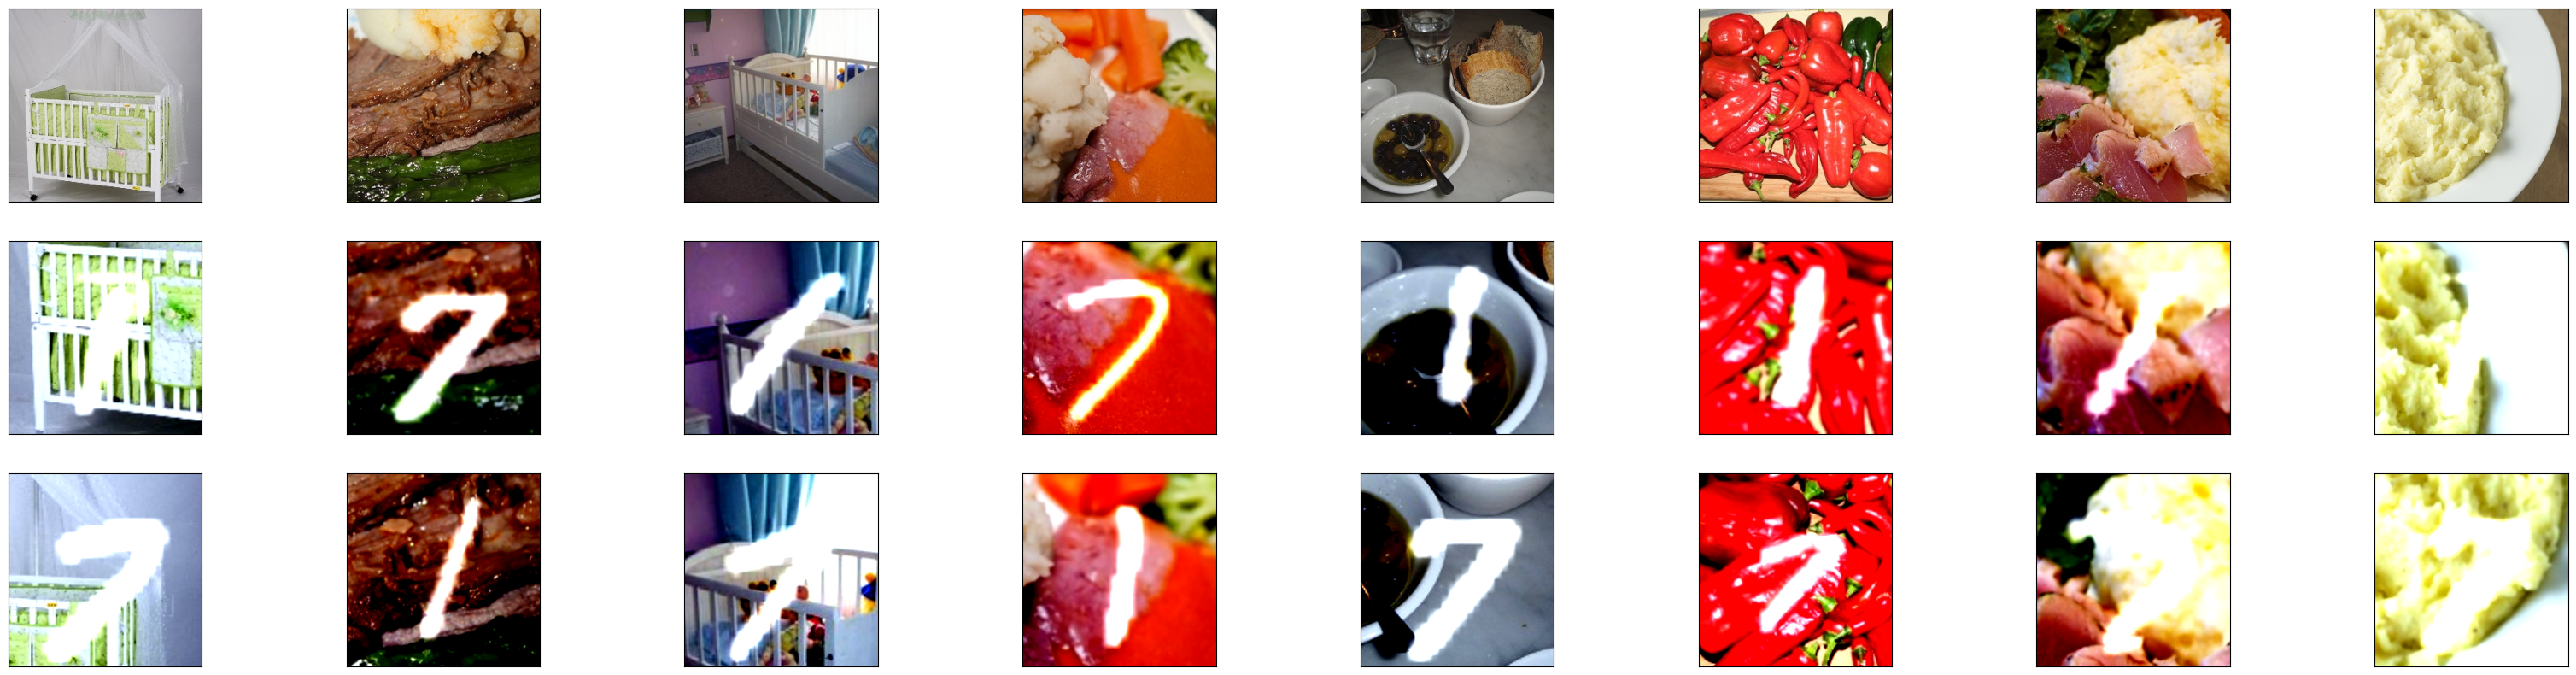

In [61]:
fig, ax = plt.subplots(3, imgs.shape[0], figsize=(40, 10))
for i in range(imgs.shape[0]):
    ax[0, i].imshow(imgs[i].permute(1, 2, 0))
    ax[1, i].imshow(deprocess_image(imgs1[i], cfg['data_mean'], cfg['data_std']))
    ax[2, i].imshow(deprocess_image(imgs2[i], cfg['data_mean'], cfg['data_std']))
    for j in range(3):
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
plt.show()

Tsai et al. use a linear projection head to perform the downstream task. We are going to use instead a k-nearest neighbor classifier. Complete the code to run the experiments (`imagenet_mnist_training.py`), train the KNN (`imagenet_mnist_exp.py`) and fill the table below:

| $I(v_1;v_2)$            | digit cls. error rate (%)     |   background cls. error rate (%)   |
| --- | --- | --- |
| digit                   |                               |                                    |
| background              |                               |                                    |
| digit, background       |                               |                                    |
